In [1]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2022-04-21 12:13:12.715675: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-21 12:13:12.715741: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sentences = []

with open('../Notebook files/sarcasm.json') as f:
  datastore = json.load(f)


for item in datastore:
  sentences.append(item['headline'])

sentences = sentences[:8000]

In [3]:
print(len(sentences))

8000


In [4]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(sentences)
total_words = len(tokenizer.word_index) + 1
word_index = tokenizer.word_index

print(len(word_index))

15828


In [5]:

input_sequences = []
for line in sentences:
  token_list = tokenizer.texts_to_sequences([line])[0]

  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i + 1]
    input_sequences.append(n_gram_sequence)

#Pad sequences.
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_sequence_len, padding = 'post'))

#Create predictors and labels.
X = input_sequences[:, :-1]
labels = input_sequences[:, -1]
y = tf.keras.utils.to_categorical(labels, num_classes = total_words)


In [6]:
print(tokenizer.word_index['in'])
print(tokenizer.word_index['the'])
print(tokenizer.word_index['capital'])

4
3
13278


In [7]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(total_words, 100, input_length = max_sequence_len - 1),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
                             tf.keras.layers.Dense(total_words, activation = 'softmax')

])

#Compile model.
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    metrics = ['accuracy']

)

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 100)           1582900   
                                                                 
 bidirectional (Bidirectiona  (None, 300)              301200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 15829)             4764529   
                                                                 
Total params: 6,648,629
Trainable params: 6,648,629
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
history = model.fit(X, y, epochs = 5, verbose = 1)

Epoch 1/5
2255/2255 [==============================] - 74s 29ms/step - loss: 0.0140 - accuracy: 0.9995
Epoch 2/5
2255/2255 [==============================] - 69s 31ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 3/5
2255/2255 [==============================] - 68s 30ms/step - loss: 0.0017 - accuracy: 0.9995
Epoch 4/5
2255/2255 [==============================] - 71s 32ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 5/5
2255/2255 [==============================] - 69s 31ms/step - loss: 0.0019 - accuracy: 1.0000


In [15]:
#Text generation.
from traitlets.traitlets import ClassTypes

next_words = 10
#Seed text.
seed_text = 'I\'ve got a feeling'

for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen = max_sequence_len - 1, padding = 'post')
  predicted = model.predict(token_list, verbose = 0)

  classes = np.argmax(predicted, axis = 1)
  output_word = ''
  for word, index in tokenizer.word_index.items():
    if index == classes:
      output_word = word
      break
    
    seed_text += '' + output_word

print(seed_text)

I've got a feeling


In [16]:
from traitlets.traitlets import ClassTypes
seed_text = "I've got a good feeling about this since "
next_words = 20
  
for _ in range(next_words):

	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict(token_list, verbose=0)
 
	classes = np.argmax(predicted, axis = 1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == classes:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

I've got a good feeling about this since                     


In [17]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.show()

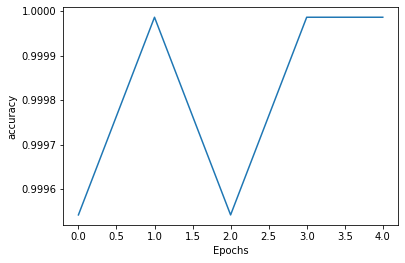

In [18]:
plot_graphs(history, 'accuracy')

In [19]:
model.save('text_generation.h5')